<a href="https://colab.research.google.com/github/cmronz/6.881_mp_2020/blob/main/ompl_benchmark_analysis_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this notebook is to do a first pass analysis as the benchmark data from the OMPL planning algorithms. More info on this benchmarking can be found [here](http://plannerarena.org/?user=pzxbeyg_&job=9bdf88e1.db#sampleBenchmarks).

# Setup

Make sure you upload the `benchmark.db` file into the Colab workspace before you proceed!

You can download this file from OMPL [here](http://plannerarena.org/benchmark.db).

# Imports

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('white')

# Setup connection & load all data

In [ ]:
con = sqlite3.connect('benchmark.db')

In [ ]:
cursor = con.cursor()
cursor.execute('SELECT name FROM sqlite_master WHERE type=\'table\'')
print(cursor.fetchall())

[('experiments',), ('sqlite_sequence',), ('plannerConfigs',), ('enums',), ('runs',), ('progress',)]


In [ ]:
enums = pd.read_sql_query('SELECT * FROM enums', con)
enums

,name,value,description
0,status,0,Unknown status
1,status,1,Invalid start
2,status,2,Invalid goal
3,status,3,Unrecognized goal type
4,status,4,Timeout
5,status,5,Approximate solution
6,status,6,Exact solution
7,status,7,Crash


In [ ]:
runs = pd.read_sql_query('SELECT * FROM runs', con)
runs.head()

,id,experimentid,plannerid,approximate_solution,correct_solution,correct_solution_strict,graph_motions,graph_states,memory,simplification_time,simplified_correct_solution,simplified_correct_solution_strict,simplified_solution_clearance,simplified_solution_length,simplified_solution_segments,simplified_solution_smoothness,solution_clearance,solution_difference,solution_length,solution_segments,solution_smoothness,solved,status,time,valid_segment_fraction,iterations,shared_paths,shared_states
0,1,1,1,0.0,1.0,1.0,1368,1369,0.511719,0.073332,1.0,1.0,8.441421,621.351092,48.0,0.319048,7.557144,0.0,1044.798581,23.0,0.056552,1,6,2.110910,0.429731,NaN,NaN,NaN
1,2,1,1,0.0,1.0,1.0,15164,15165,4.558594,0.103840,1.0,1.0,8.498797,567.327627,64.0,0.650953,31.794648,0.0,16437.018285,235.0,0.243308,1,6,22.316997,0.434312,NaN,NaN,NaN
2,3,1,1,0.0,1.0,1.0,4163,4164,4.765625,0.113646,1.0,1.0,8.931178,814.911032,48.0,0.286132,34.511685,0.0,19802.108253,278.0,0.282846,1,6,6.331082,0.442413,NaN,NaN,NaN
3,4,1,1,0.0,1.0,1.0,2183,2184,5.792969,0.119785,1.0,1.0,13.113954,1534.796974,96.0,0.380955,29.785371,0.0,12011.231473,171.0,0.175643,1,6,3.354857,0.429408,NaN,NaN,NaN
4,5,1,1,0.0,1.0,1.0,1549,1550,5.792969,0.096814,1.0,1.0,7.184069,541.523438,72.0,0.846310,38.589687,0.0,7341.722407,101.0,0.082405,1,6,2.486722,0.433804,NaN,NaN,NaN


In [ ]:
experiments = pd.read_sql_query('SELECT * FROM experiments', con)
experiments.head()

,id,name,totaltime,timelimit,memorylimit,runcount,version,hostname,cpuinfo,date,seed,setup
0,1,Abstract,41167.60,300.0,8000.0,50,0.15.0,zeus,Architecture: x86_64\nCPU op-mode(s):...,2014-09-20T22:59:27.445958,633636476,Properties of the state space 'SE3CompoundSpac...
1,2,BugTrap_dcar,91400.70,300.0,20000.0,50,0.15.0,zeus,Architecture: x86_64\nCPU op-mode(s):...,2014-09-20T23:01:37.328893,763548376,Properties of the state space 'CompoundSpace1'...
2,3,Home,150725.00,300.0,10000.0,50,0.15.0,zeus,Architecture: x86_64\nCPU op-mode(s):...,2014-09-26T20:03:53.234373,1693292832,Properties of the state space 'SE3CompoundSpac...
3,4,Maze_kinematic_car,6106.49,20.0,1000.0,50,0.15.0,zeus,Architecture: x86_64\nCPU op-mode(s):...,2014-09-20T23:01:43.981347,770196779,Properties of the state space 'SE2CompoundSpac...
4,5,cubicles,1992.70,20.0,1000.0,50,0.15.0,zeus,Architecture: x86_64\nCPU op-mode(s):...,2014-09-20T22:59:27.431773,633632764,Properties of the state space 'SE3CompoundSpac...


In [ ]:
planner_configs = pd.read_sql('SELECT * FROM plannerConfigs', con)
planner_configs.head()

,id,name,settings
0,1,geometric_BKPIECE1,border_fraction = 0.90000000000000002\n;failed...
1,2,geometric_EST,goal_bias = 0.050000000000000003\n;longest_val...
2,3,geometric_KPIECE1,border_fraction = 0.90000000000000002\n;failed...
3,4,geometric_LBKPIECE1,border_fraction = 0.90000000000000002\n;longes...
4,5,geometric_PDST,goal_bias = 0.050000000000000003\n;longest_val...


In [ ]:
progress = pd.read_sql_query('SELECT * FROM progress', con)
progress.head()

,runid,time,best_cost,iterations,shared_paths,shared_states
0,251,0.500102,NaN,116.0,NaN,NaN
1,251,1.000195,NaN,194.0,NaN,NaN
2,251,1.500289,NaN,290.0,NaN,NaN
3,251,2.000384,NaN,374.0,NaN,NaN
4,251,2.500461,NaN,449.0,NaN,NaN


# Understand basic data distributions

In [ ]:
runs.shape

(3500, 28)

In [ ]:
planner_configs.shape

(67, 3)

In [ ]:
experiments.shape

(10, 12)

In [ ]:
progress.shape

(673030, 6)

In [ ]:
runs_merged = runs. \
  merge(right=planner_configs[['id', 'name']], left_on='plannerid', right_on='id', suffixes=('', '_y')). \
  rename({'id_y': 'planner_id', 'name': 'planner_name'}, axis=1)

In [ ]:
runs_avg = runs_merged.groupby(by='planner_name').mean()

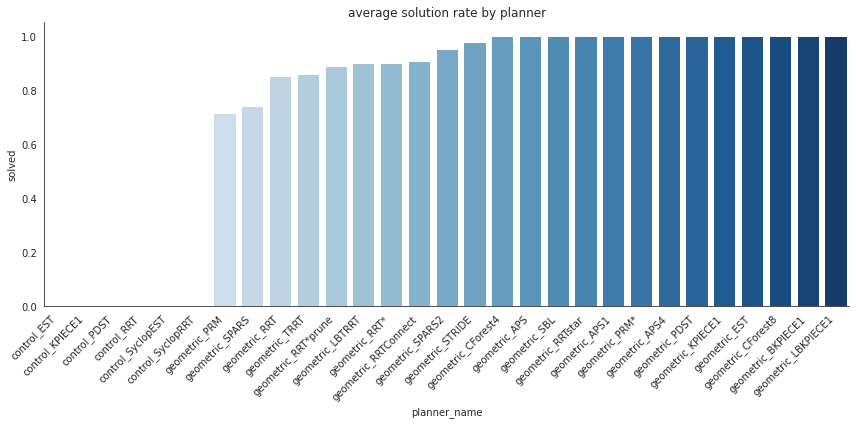

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
  x=runs_avg.sort_values(by='solved').index,
  y=runs_avg.sort_values(by='solved').solved,
  data=runs_avg,
  ax=ax,
  palette='Blues'
)
sns.despine()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('average solution rate by planner')
plt.tight_layout()
plt.show()

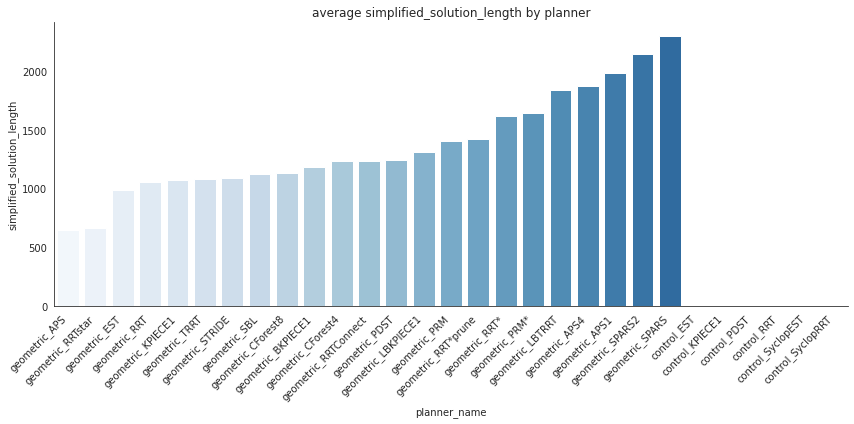

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
  x=runs_avg.sort_values(by='simplified_solution_length').index,
  y=runs_avg.sort_values(by='simplified_solution_length').simplified_solution_length,
  data=runs_avg,
  ax=ax,
  palette='Blues'
)
sns.despine()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('average simplified_solution_length by planner')
plt.tight_layout()
plt.show()

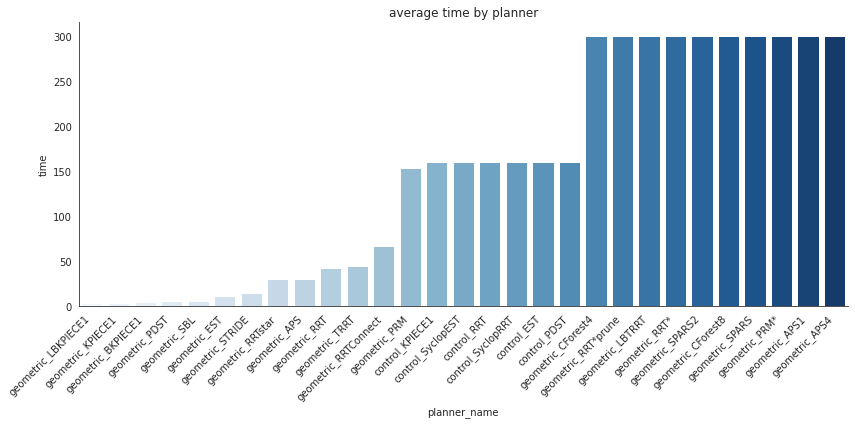

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
  x=runs_avg.sort_values(by='time').index,
  y=runs_avg.sort_values(by='time').time,
  data=runs_avg,
  ax=ax,
  palette='Blues'
)
sns.despine()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('average time by planner')
plt.tight_layout()
plt.show()

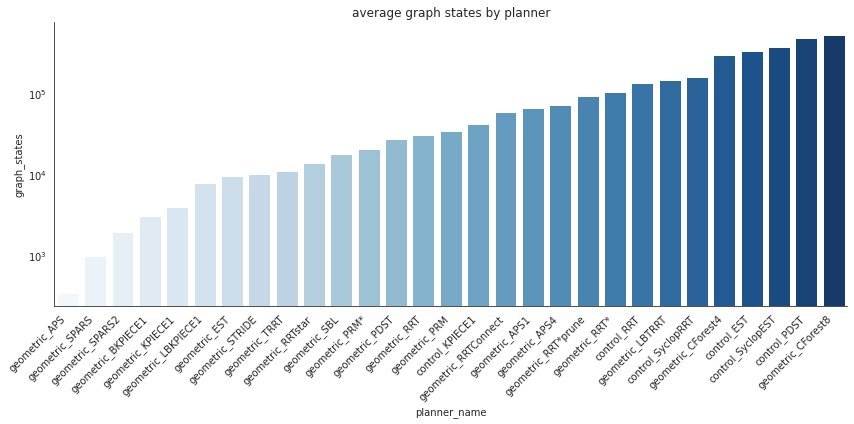

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
  x=runs_avg.sort_values(by='graph_states').index,
  y=runs_avg.sort_values(by='graph_states').graph_states,
  data=runs_avg,
  ax=ax,
  palette='Blues'
)
sns.despine()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('average graph states by planner')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

# So what's important here?

In [ ]:
list(runs.columns)

['id',
 'experimentid',
 'plannerid',
 'approximate_solution',
 'correct_solution',
 'correct_solution_strict',
 'graph_motions',
 'graph_states',
 'memory',
 'simplification_time',
 'simplified_correct_solution',
 'simplified_correct_solution_strict',
 'simplified_solution_clearance',
 'simplified_solution_length',
 'simplified_solution_segments',
 'simplified_solution_smoothness',
 'solution_clearance',
 'solution_difference',
 'solution_length',
 'solution_segments',
 'solution_smoothness',
 'solved',
 'status',
 'time',
 'valid_segment_fraction',
 'iterations',
 'shared_paths',
 'shared_states']

In [ ]:
runs_corr = runs[[
  'graph_motions',
  'graph_states',
  'memory',
  'simplification_time',
  'simplified_correct_solution',
  'simplified_correct_solution_strict',
  'simplified_solution_clearance',
  'simplified_solution_length',
  'simplified_solution_segments',
  'simplified_solution_smoothness',
  'solution_clearance',
  'solution_difference',
  'solution_length',
  'solution_segments',
  'solution_smoothness',
  'solved',
  'shared_paths',
  'shared_states',
]]

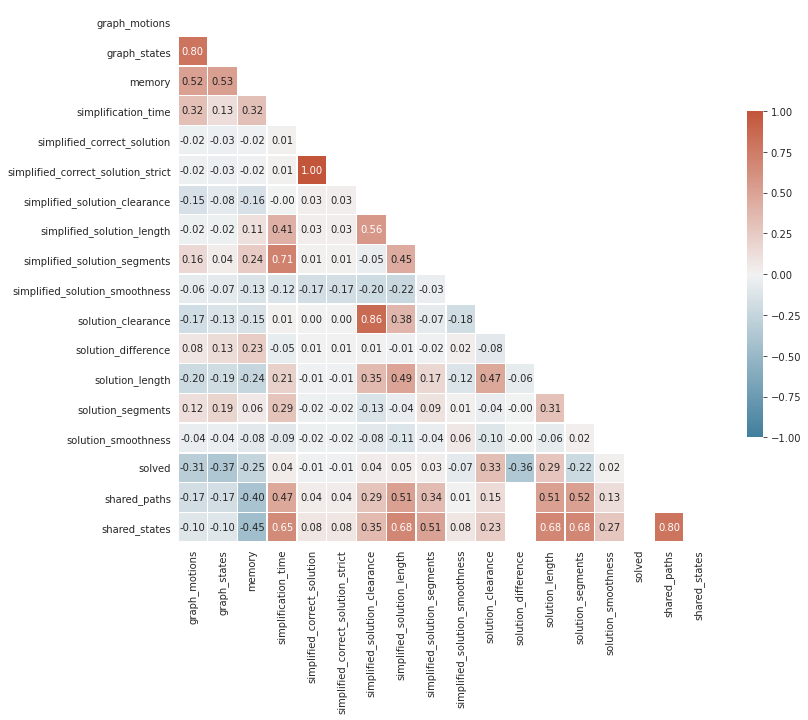

In [ ]:
# Compute the correlation matrix
corr = runs_corr.corr()

# Generate a mask for the upper triangle, such that only the sub-diagonal entries are shown
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(h_neg=230, h_pos=20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio, and annotate the correlation coefficient
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f", ax=ax)
plt.show()

What are the various planners that we have here?

In [ ]:
planner_configs.groupby(by=['name', 'id']).first()

settings
name             id                                                   
control_EST      12  goal_bias = 0.050000000000000003\n;longest_val...
                 28  goal_bias = 0.050000000000000003\n;longest_val...
control_KPIECE1  13  bad_score_factor = 0.45000000000000001\n;borde...
control_PDST     14  goal_bias = 0.050000000000000003\n;longest_val...
control_RRT      15  goal_bias = 0.050000000000000003\n;intermediat...
...                                                                ...
geometric_STRIDE 59  degree = 16\n;estimated_dimension = 6\n;goal_b...
                 63  degree = 16\n;estimated_dimension = 20\n;goal_...
geometric_TRRT   11  frontierNodeRatio = 0.10000000000000001\n;fron...
                 39  frontierNodeRatio = 0.10000000000000001\n;fron...
                 60  frontierNodeRatio = 0.10000000000000001\n;fron...

[67 rows x 1 columns]

So, we have multiple planner ID's for a given parameter because they can have different "settings"! This is important to understand.

# Let's focus in on RRT

In [ ]:
RRT_planner_names = planner_configs.name[planner_configs.name.str.lower().str.contains('rrt')].unique()
RRT_planner_names

array(['geometric_RRT', 'geometric_RRTConnect', 'geometric_TRRT',
       'control_RRT', 'control_SyclopRRT', 'geometric_LBTRRT',
       'geometric_RRT*', 'geometric_RRT*prune', 'geometric_RRTstar'],
      dtype=object)

In [ ]:
RRT_data = runs_avg[runs_avg.index.isin(RRT_planner_names)]

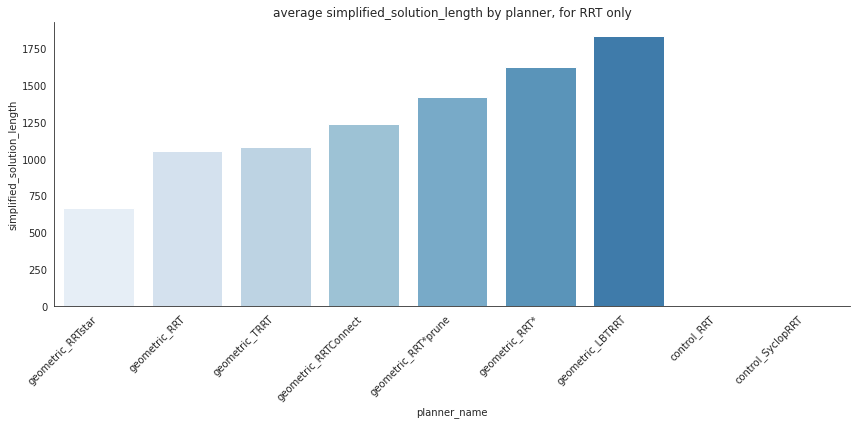

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
  x=RRT_data.sort_values(by='simplified_solution_length').index,
  y=RRT_data.sort_values(by='simplified_solution_length').simplified_solution_length,
  data=RRT_data,
  ax=ax,
  palette='Blues'
)
sns.despine()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('average simplified_solution_length by planner, for RRT only')
plt.tight_layout()
plt.show()

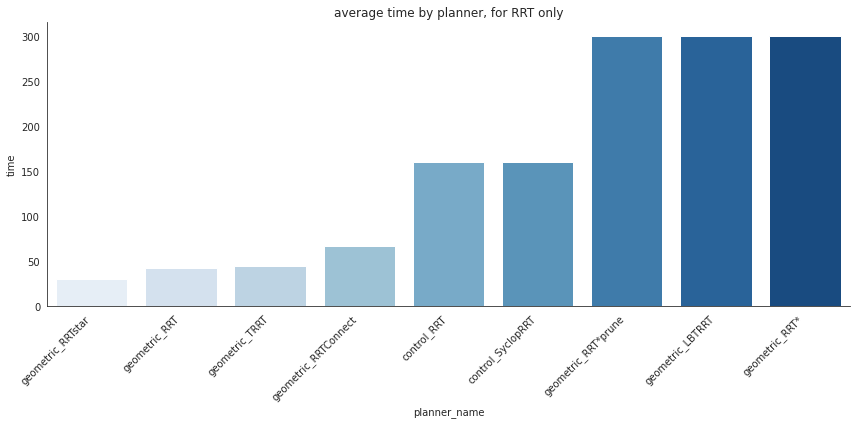

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
  x=RRT_data.sort_values(by='time').index,
  y=RRT_data.sort_values(by='time').time,
  data=RRT_data,
  ax=ax,
  palette='Blues'
)
sns.despine()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('average time by planner, for RRT only')
plt.tight_layout()
plt.show()